# 9DR_vocab_go_cancer_crmgenes.ipynb


6/16/2021

similar to dk Fig 6A combinatorl motif go stuff 
# plots

# 1 TF expression by tissue

# 2. Dot plot to connect cooperative TFs
# 3. go terms associated with target genes of cooperative TFS

In [2]:
library(tidyverse)
library(pheatmap)

library(RColorBrewer)
library(clusterProfiler)
library(ReactomePA)
library(annotate)
library( org.Hs.eg.db ) 
library(AnnotationDbi) 
library(Biobase)


save_pheatmap_png <- function(x, filename, width=1200, height=1000, res = 200) {
  png(filename, width = width, height = height, res = res)
  grid::grid.newpage()
  grid::grid.draw(x$gtable)
  dev.off()
}
save_pheatmap_pdf <- function(x, filename, width=7, height=7) {
   stopifnot(!missing(x))
   stopifnot(!missing(filename))
   pdf(filename, width=width, height=height)
   grid::grid.newpage()
   grid::grid.draw(x$gtable)
   dev.off()
}

In [3]:
save_prefix ='../data/processed/fig7_vocab_go/cancer/'

In [4]:
tissue_colors = read.csv( '../data/processed/fig3_footprinting/tissue_colors.csv',stringsAsFactors=F)
# tissue_colors

In [5]:
tissue_colors = rbind(tissue_colors,c('MM','#7D639E'),c('SCC','#DDB1AD'))
tissue_colors
#

tissue,color
<chr>,<chr>
Airway,#4A195D
Astrocytes,#A8EAFF
Bladder,#C2A7D2
Colon,#F5AF1A
Esophageal,#FFDA89
GDSD0,#240201
GDSD3,#4E0A05
GDSD6,#A22633
GM12878,#8F99AC



# 1 TF expression by tissue

# 2. Dot plot to connect cooperative TFs


In [6]:
vocab_df = read.csv('../data/processed/mpra/results_df_piv_match_count.csv',
                                     stringsAsFactor=F)
cancer_vocab_df = vocab_df%>%
    filter(tissue%in% c('MM','SCC'))
cancer_vocab_df_coop = cancer_vocab_df%>%
    filter(consensus_class=='AND')%>%
    arrange(tissue,vocab)%>%
    mutate(index=row_number())%>%
    left_join(tissue_colors, by='tissue')
str(cancer_vocab_df_coop)
cancer_vocab_df_coop1 = cancer_vocab_df_coop[,c("tf1",'index','tissue','color')]
colnames(cancer_vocab_df_coop1) = c("tf_name",'number','tissue','color')
cancer_vocab_df_coop2 = cancer_vocab_df_coop[,c("tf2",'index','tissue','color')]
colnames(cancer_vocab_df_coop2) = c("tf_name",'number','tissue','color')
cancer_vocab_df_long = rbind(cancer_vocab_df_coop1, cancer_vocab_df_coop2)
cancer_vocab_df_long$score = .5
str(cancer_vocab_df_long)

'data.frame':	20 obs. of  12 variables:
 $ X              : int  1 31 43 66 165 167 172 174 203 204 ...
 $ vocab          : chr  "ARID5B::LEF1" "EGR2::NFE2L1" "EN2::STAT1" "HBP1::STAT1" ...
 $ tissue         : chr  "MM" "MM" "MM" "MM" ...
 $ mpra_tissue    : chr  "COLO" "COLO" "COLO" "COLO" ...
 $ class          : chr  "other|LEADING_B|other|OR|OR|AND|other|other|AND|other" "other|other|AND|OR|other|OR|AND|other|other|other" "XOR|AND|OR|LEADING_B|AND|AND|LEADING_B|other|other|other" "other|other|other|other|AND|AND|other|other|LEADING_B|other" ...
 $ instance       : chr  "1|10|2|3|4|5|6|7|8|9" "1|10|2|3|4|5|6|7|8|9" "1|10|2|3|4|5|6|7|8|9" "1|10|2|3|4|5|6|7|8|9" ...
 $ count          : int  10 10 10 10 10 10 10 10 10 10 ...
 $ consensus_class: chr  "AND" "AND" "AND" "AND" ...
 $ tf1            : chr  "ARID5B" "EGR2" "EN2" "HBP1" ...
 $ tf2            : chr  "LEF1" "NFE2L1" "STAT1" "STAT1" ...
 $ index          : int  1 2 3 4 5 6 7 8 9 10 ...
 $ color          : chr  "#7D639E" "#7D639E"

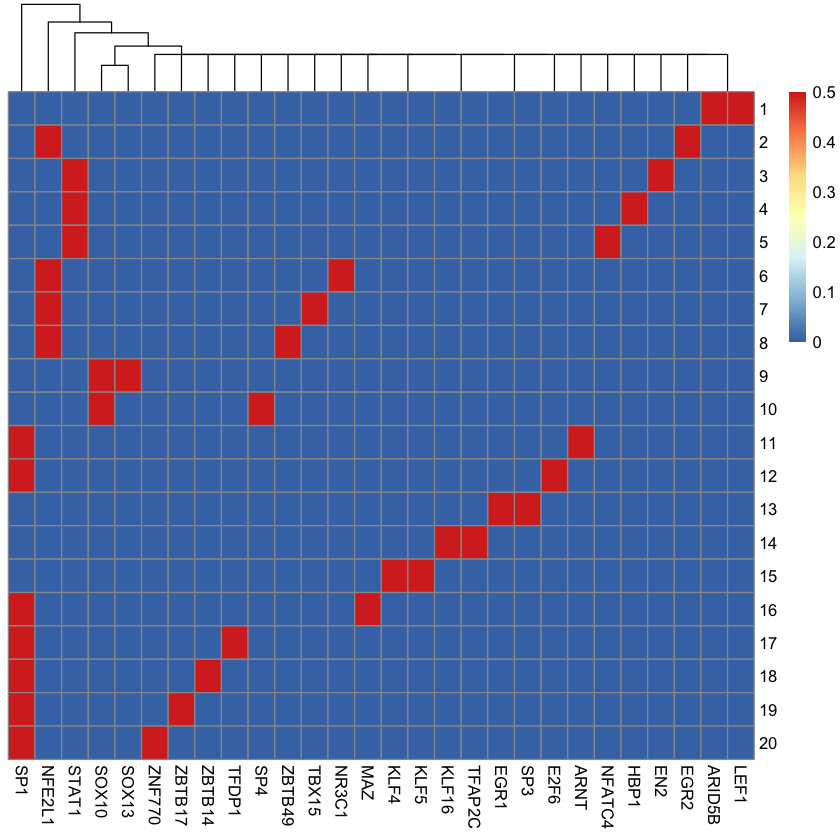

In [7]:
cancer_vocab_df_spread = cancer_vocab_df_long%>%
    dplyr::select(tf_name, score,number)%>%
    pivot_wider(names_from = tf_name, values_from = score)%>%
    column_to_rownames("number")
cancer_vocab_df_spread[is.na(cancer_vocab_df_spread)] = 0
p = pheatmap(cancer_vocab_df_spread,
        cluster_row=F)
tf_order = colnames(cancer_vocab_df_spread)[p$tree_col[['order']]]

In [8]:
rna_tpm_file_tissue = '../data/interim/rna/tissue_tpm_sym.csv'
rna_df_tissue = read.csv(rna_tpm_file_tissue, row.names=1,stringsAsFactors=F,check.names = FALSE)
rna_df_tissue = rna_df_tissue[tf_order,]
rna_df_tissue$SCC = rowMeans(rna_df_tissue[,c('A431-CTRLi','CAL27-CTRLi','SCC13-CTRLi')])
rna_df_tissue$MM = rowMeans(rna_df_tissue[,c('COLO_SCR_DMSO','SKMEL5_SCR_DMSO','WM_SCR_DMSO')])
rna_df_tissue_log = log2(rna_df_tissue+1)
rna_df_tissue_norm = as.data.frame(scale(rna_df_tissue_log, center = TRUE, scale = TRUE))
rna_df_tissue_norm[rna_df_tissue_norm>2] = 2
rna_df_tissue_norm[rna_df_tissue_norm < -2] = -2
rna_df_tissue_log[rna_df_tissue_log>5] = 5
head(rna_df_tissue_norm)

,A431-CTRLi,A431-p63i,Airway,Astrocytes,Bladder,CAL27-CTRLi,CAL27-p63i,COLO_SCR_DMSO,COLO_SCR_PLX,COLO_shMITF_DMSO,⋯,SKMEL5_shMITF-DMSO,SKMEL5_shMITF_PLX,Thyroid,Uterine,WM_SCR_DMSO,WM_SCR_PLX,WM_shMITF_DMSO,WM_shMITF_PLX,SCC,MM
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
SP1,-0.1442791,-0.1240608,-0.3998392,-0.5090956,-0.4358274,-0.2566620,-0.1376457,-0.5447568,-0.0661091,-0.4449557,⋯,-0.2211211,-0.2010762,-0.0497336,-0.3148094,-0.7245550,-0.5954816,-0.7441356,-0.5708540,-0.3063563,-0.6528009
NFE2L1,0.9736438,0.8836377,1.0572477,1.2398827,1.2734583,0.6210080,0.9446249,1.0827080,1.3710555,1.0765025,⋯,1.0648391,0.9718912,0.8247849,1.4458526,0.8409030,0.8620308,0.9294204,0.8990847,0.7627509,0.9096032
STAT1,0.5329133,0.9165348,0.4354528,0.4534061,0.7178294,1.1678768,1.3836702,0.5426531,0.8946988,0.4777214,⋯,0.6663980,0.6341696,0.8022361,1.0174109,1.8077711,1.8955719,1.8729696,2.0000000,1.0558071,1.4383451
SOX10,-1.3027924,-1.3250940,-1.2931683,-1.3825121,-1.2633111,-1.2743502,-1.4162723,0.9202860,1.5520428,0.9282163,⋯,1.2311641,1.4024507,-1.4137017,-1.3511440,0.8440568,1.2127290,1.0042106,1.3404721,-1.3854491,0.8949712
SOX13,-0.5678664,-0.4361751,-0.6004720,-1.0092106,-0.6353966,-0.6833408,-0.9132260,-0.7984736,-0.4243163,-0.8699176,⋯,-0.9552661,-0.5907893,-0.3002334,-0.3165151,-0.7188624,-0.9744745,-1.1744643,-1.2325719,-0.6681648,-0.9016582
ZNF770,-0.7428216,-0.6769660,0.2722840,0.1913637,0.4127799,-0.5542383,-0.6961528,-0.7583957,-0.7430661,-0.8014285,⋯,-0.8421519,-0.9578181,0.1728876,0.5017222,-1.0294822,-1.0958135,-1.0738996,-0.9884127,-0.7334802,-0.9893940


In [9]:
tissue_colors_filt = filter(tissue_colors, tissue %in%unique(cancer_vocab_df_long$tissue))
tissue_colors_filt

tissue,color
<chr>,<chr>
MM,#7D639E
SCC,#DDB1AD


In [10]:
length(tf_order)
print(tf_order)

[1] 28

 [1] "SP1"    "NFE2L1" "STAT1"  "SOX10"  "SOX13"  "ZNF770" "ZBTB17" "ZBTB14"
 [9] "TFDP1"  "SP4"    "ZBTB49" "TBX15"  "NR3C1"  "MAZ"    "KLF4"   "KLF5"  
[17] "KLF16"  "TFAP2C" "EGR1"   "SP3"    "E2F6"   "ARNT"   "NFATC4" "HBP1"  
[25] "EN2"    "EGR2"   "ARID5B" "LEF1"  


In [16]:
# manual 
tf_order_manual = c('ARID5B','LEF1',"NFE2L1" ,"ZBTB49" ,"TBX15" , "NR3C1" ,
                    "STAT1",  "SOX10",  "SOX13",  "NFATC4", "HBP1",   "EGR2"  ,"EN2" ,"SP4" ,   
                    "SP1" ,"ZNF770","ZBTB17", "ZBTB14", "TFDP1" , "MAZ"  ,  "KLF4"  , "KLF5"  , "KLF16" ,"TFAP2C" ,"EGR1" ,  "SP3"  ,  "E2F6"  , "ARNT" 
            )
length(unique(tf_order_manual))
tf_order = tf_order_manual

[1] 28

In [17]:
tf_order[!(tf_order %in% tf_order_manual)]

character(0)

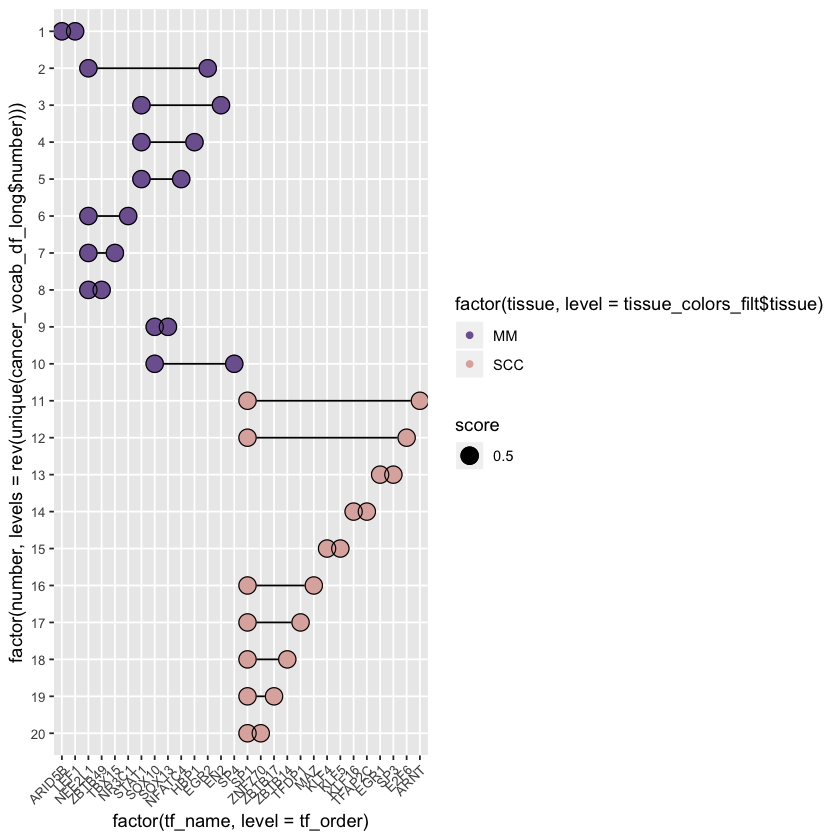

In [18]:
p = ggplot(cancer_vocab_df_long, aes(x=factor(tf_name,level=tf_order),y= factor(number, levels=rev(unique(cancer_vocab_df_long$number))),
                                          color=factor(tissue, level=tissue_colors_filt$tissue)))+
    geom_line(aes(group = factor(number)),color='black')+geom_point(aes(size=score))+ 
    scale_color_manual(values=tissue_colors_filt$color)+
    geom_point(aes(size=score),colour="black",pch=21)+
    theme(axis.text.y = element_text(size=8),
          axis.text.x = element_text(size=8, angle = 45,hjust=1))
p 
ggsave(file = paste0(save_prefix, "cancer_vocab_tissue_pairs.eps"),height=4, width=8)
#

In [19]:
rna_df_tissue['SP4',tissue_colors_filt$tissue]#c('GDSD0','GDSD3','GDSD6','SCC','A431-CTRLi','CAL27-CTRLi','SCC13-CTRLi')]

,MM,SCC
,<dbl>,<dbl>
SP4,2.2,1.99


pdf 
  2

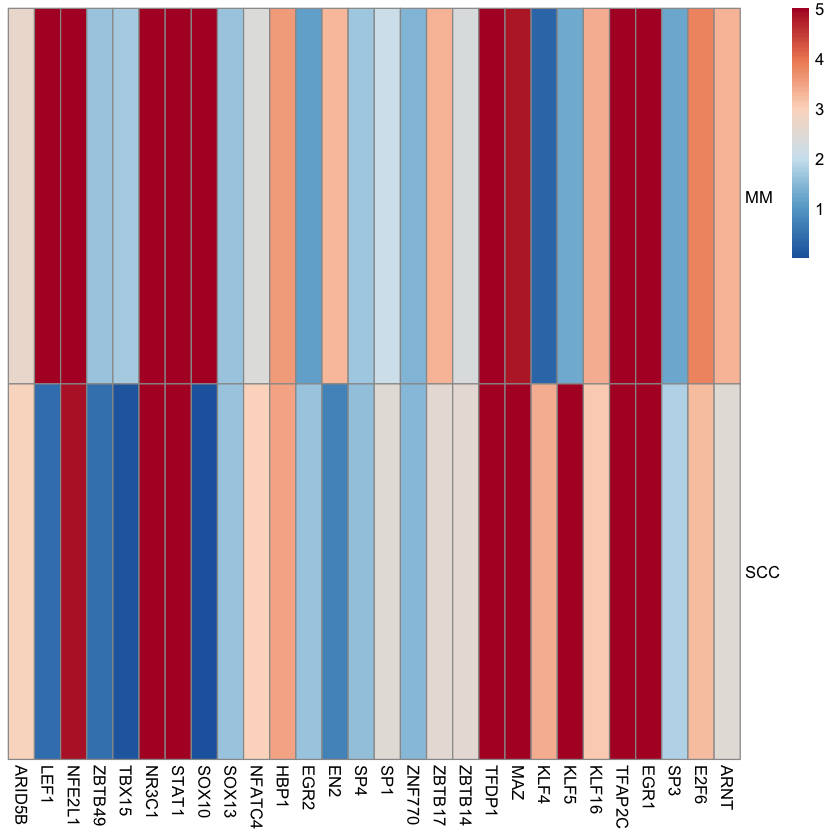

In [20]:
p_genexp = pheatmap(t(rna_df_tissue_log[tf_order,tissue_colors_filt$tissue]),
                    color = colorRampPalette(rev(brewer.pal(n =6, name ="RdBu")))(100),

                    cluster_rows=F,cluster_cols=F)
save_pheatmap_pdf(p_genexp, paste0(save_prefix, 'camcer_vocab_rna_heatmap.pdf'),  height=1.3,width=6) 

# 3. go terms associated with target genes of cooperative TFS

make sure genesets exist, if not create in 9B_vocab_goterms

In [21]:
read_genes = function(filename){
    print(filename)
    target_genes = read.csv(filename,header=FALSE,stringsAsFactors=F)$V1
    print(length(target_genes))
    target_genes_entrez = bitr(target_genes, fromType="SYMBOL", toType="ENTREZID", OrgDb="org.Hs.eg.db")$ENTREZID
    print(length(target_genes_entrez))
    return(target_genes_entrez)
}

In [22]:
# vocab_list = c('ARNT::SP1', 'BACH1::KLF5', 'E2F6::SP1', 'E2F7::THAP1',
#        'EBF1::SP4', 'EGR1::SP3', 'EGR2::FOSL2', 'EGR2::NFE2L1',
#        'EGR2::RARG', 'EGR2::RORA', 'EN2::STAT1', 'ETV2::PRRX1',
#        'FOXD3::PRRX1', 'FOXM1::KLF15', 'HBP1::IRF8', 'HBP1::STAT1',
#        'HMGA1::KLF5', 'IKZF1::ZNF563', 'IRF4::SP4', 'IRF8::SPIB',
#        'IRF8::ZBTB49', 'KLF15::OTX1', 'KLF15::SNAI2', 'KLF15::ZNF589',
#        'KLF16::TFAP2C', 'KLF4::KLF5', 'KLF5::MAFG', 'KLF5::MAFK',
#        'KLF5::NFYB', 'KLF5::NR2F1', 'KLF5::RUNX3', 'KLF5::SOX13',
#        'MAF::RORA', 'MAZ::SP1', 'MITF::ZNF589', 'NFATC4::STAT1',
#        'NFE2L1::NR3C1', 'NFE2L1::TBX15', 'NFE2L1::ZBTB49', 'OSR2::THAP1',
#        'PRDM1::RORA', 'SOX10::SOX13', 'SOX10::SP4', 'SP1::TFDP1',
#        'SP1::ZBTB14', 'SP1::ZBTB17', 'SP4::THAP1')# see 17_vocab_classes


In [23]:
cancer_vocab_df_coop = cancer_vocab_df_coop%>%
    mutate(vocab_file=str_c(tissue, '_',tf1, '-',tf2))

In [24]:
vocab_list = cancer_vocab_df_coop$vocab_file
print(vocab_list) # 18 vocab words

 [1] "MM_ARID5B-LEF1"   "MM_EGR2-NFE2L1"   "MM_EN2-STAT1"     "MM_HBP1-STAT1"   
 [5] "MM_NFATC4-STAT1"  "MM_NFE2L1-NR3C1"  "MM_NFE2L1-TBX15"  "MM_NFE2L1-ZBTB49"
 [9] "MM_SOX10-SOX13"   "MM_SOX10-SP4"     "SCC_ARNT-SP1"     "SCC_E2F6-SP1"    
[13] "SCC_EGR1-SP3"     "SCC_KLF16-TFAP2C" "SCC_KLF4-KLF5"    "SCC_MAZ-SP1"     
[17] "SCC_SP1-TFDP1"    "SCC_SP1-ZBTB14"   "SCC_SP1-ZBTB17"   "SCC_SP1-ZNF770"  


In [25]:
# create a list of all possible entrez ids that you care about
all_genes = c()
for (vocab in vocab_list){
    filename = paste0('../data/processed/fig7_vocab_go/vocab_genesets/', vocab, '.txt')
    genes = read_genes(filename)
    all_genes = c(all_genes, genes)
}
all_genes = unique(all_genes)
length(all_genes)

[1] "../data/processed/fig7_vocab_go/vocab_genesets/MM_ARID5B-LEF1.txt"
[1] 464


'select()' returned 1:1 mapping between keys and columns



[1] 464
[1] "../data/processed/fig7_vocab_go/vocab_genesets/MM_EGR2-NFE2L1.txt"
[1] 610


'select()' returned 1:1 mapping between keys and columns



[1] 610
[1] "../data/processed/fig7_vocab_go/vocab_genesets/MM_EN2-STAT1.txt"
[1] 459


'select()' returned 1:1 mapping between keys and columns



[1] 459
[1] "../data/processed/fig7_vocab_go/vocab_genesets/MM_HBP1-STAT1.txt"
[1] 467


'select()' returned 1:1 mapping between keys and columns



[1] 467
[1] "../data/processed/fig7_vocab_go/vocab_genesets/MM_NFATC4-STAT1.txt"
[1] 615


'select()' returned 1:1 mapping between keys and columns



[1] 615
[1] "../data/processed/fig7_vocab_go/vocab_genesets/MM_NFE2L1-NR3C1.txt"
[1] 522


'select()' returned 1:1 mapping between keys and columns



[1] 522
[1] "../data/processed/fig7_vocab_go/vocab_genesets/MM_NFE2L1-TBX15.txt"
[1] 580


'select()' returned 1:1 mapping between keys and columns



[1] 580
[1] "../data/processed/fig7_vocab_go/vocab_genesets/MM_NFE2L1-ZBTB49.txt"
[1] 599


'select()' returned 1:1 mapping between keys and columns



[1] 599
[1] "../data/processed/fig7_vocab_go/vocab_genesets/MM_SOX10-SOX13.txt"
[1] 627


'select()' returned 1:1 mapping between keys and columns



[1] 627
[1] "../data/processed/fig7_vocab_go/vocab_genesets/MM_SOX10-SP4.txt"
[1] 542


'select()' returned 1:1 mapping between keys and columns



[1] 542
[1] "../data/processed/fig7_vocab_go/vocab_genesets/SCC_ARNT-SP1.txt"
[1] 828


'select()' returned 1:1 mapping between keys and columns



[1] 828
[1] "../data/processed/fig7_vocab_go/vocab_genesets/SCC_E2F6-SP1.txt"
[1] 1385


'select()' returned 1:1 mapping between keys and columns



[1] 1385
[1] "../data/processed/fig7_vocab_go/vocab_genesets/SCC_EGR1-SP3.txt"
[1] 1432


'select()' returned 1:1 mapping between keys and columns



[1] 1432
[1] "../data/processed/fig7_vocab_go/vocab_genesets/SCC_KLF16-TFAP2C.txt"
[1] 1220


'select()' returned 1:1 mapping between keys and columns



[1] 1220
[1] "../data/processed/fig7_vocab_go/vocab_genesets/SCC_KLF4-KLF5.txt"
[1] 1509


'select()' returned 1:1 mapping between keys and columns



[1] 1509
[1] "../data/processed/fig7_vocab_go/vocab_genesets/SCC_MAZ-SP1.txt"
[1] 1583


'select()' returned 1:1 mapping between keys and columns



[1] 1583
[1] "../data/processed/fig7_vocab_go/vocab_genesets/SCC_SP1-TFDP1.txt"
[1] 1189


'select()' returned 1:1 mapping between keys and columns



[1] 1189
[1] "../data/processed/fig7_vocab_go/vocab_genesets/SCC_SP1-ZBTB14.txt"
[1] 1018


'select()' returned 1:1 mapping between keys and columns



[1] 1018
[1] "../data/processed/fig7_vocab_go/vocab_genesets/SCC_SP1-ZBTB17.txt"
[1] 1539


'select()' returned 1:1 mapping between keys and columns



[1] 1539
[1] "../data/processed/fig7_vocab_go/vocab_genesets/SCC_SP1-ZNF770.txt"
[1] 1523


'select()' returned 1:1 mapping between keys and columns



[1] 1523


[1] 2046

In [26]:
# takes ~10-20 min
go_table_all_vocab = data.frame()
for (vocab in vocab_list){
    filename = paste0('../data/processed/fig7_vocab_go/vocab_genesets/', vocab, '.txt')
    genes = read_genes(filename)
    ego <- enrichGO(gene          = genes,
                universe      = all_genes,
                OrgDb         = org.Hs.eg.db,
                ont           = "BP",
                pAdjustMethod = "BH",
                pvalueCutoff  = 1,###SET
                qvalueCutoff  = 1,###SET
        readable      = TRUE)
    
    ego = data.frame(ego)
    print(dim(ego))
    if (dim(ego)[1]>0){
        ego$vocab = vocab
        go_table_all_vocab = rbind(go_table_all_vocab, ego)
    }
}


[1] "../data/processed/fig7_vocab_go/vocab_genesets/MM_ARID5B-LEF1.txt"
[1] 464


'select()' returned 1:1 mapping between keys and columns



[1] 464
[1] 2193    9
[1] "../data/processed/fig7_vocab_go/vocab_genesets/MM_EGR2-NFE2L1.txt"
[1] 610


'select()' returned 1:1 mapping between keys and columns



[1] 610
[1] 2232    9
[1] "../data/processed/fig7_vocab_go/vocab_genesets/MM_EN2-STAT1.txt"
[1] 459


'select()' returned 1:1 mapping between keys and columns



[1] 459
[1] 2202    9
[1] "../data/processed/fig7_vocab_go/vocab_genesets/MM_HBP1-STAT1.txt"
[1] 467


'select()' returned 1:1 mapping between keys and columns



[1] 467
[1] 2193    9
[1] "../data/processed/fig7_vocab_go/vocab_genesets/MM_NFATC4-STAT1.txt"
[1] 615


'select()' returned 1:1 mapping between keys and columns



[1] 615
[1] 2224    9
[1] "../data/processed/fig7_vocab_go/vocab_genesets/MM_NFE2L1-NR3C1.txt"
[1] 522


'select()' returned 1:1 mapping between keys and columns



[1] 522
[1] 2219    9
[1] "../data/processed/fig7_vocab_go/vocab_genesets/MM_NFE2L1-TBX15.txt"
[1] 580


'select()' returned 1:1 mapping between keys and columns



[1] 580
[1] 2231    9
[1] "../data/processed/fig7_vocab_go/vocab_genesets/MM_NFE2L1-ZBTB49.txt"
[1] 599


'select()' returned 1:1 mapping between keys and columns



[1] 599
[1] 2238    9
[1] "../data/processed/fig7_vocab_go/vocab_genesets/MM_SOX10-SOX13.txt"
[1] 627


'select()' returned 1:1 mapping between keys and columns



[1] 627
[1] 2235    9
[1] "../data/processed/fig7_vocab_go/vocab_genesets/MM_SOX10-SP4.txt"
[1] 542


'select()' returned 1:1 mapping between keys and columns



[1] 542
[1] 2228    9
[1] "../data/processed/fig7_vocab_go/vocab_genesets/SCC_ARNT-SP1.txt"
[1] 828


'select()' returned 1:1 mapping between keys and columns



[1] 828
[1] 2242    9
[1] "../data/processed/fig7_vocab_go/vocab_genesets/SCC_E2F6-SP1.txt"
[1] 1385


'select()' returned 1:1 mapping between keys and columns



[1] 1385
[1] 2244    9
[1] "../data/processed/fig7_vocab_go/vocab_genesets/SCC_EGR1-SP3.txt"
[1] 1432


'select()' returned 1:1 mapping between keys and columns



[1] 1432
[1] 2244    9
[1] "../data/processed/fig7_vocab_go/vocab_genesets/SCC_KLF16-TFAP2C.txt"
[1] 1220


'select()' returned 1:1 mapping between keys and columns



[1] 1220
[1] 2244    9
[1] "../data/processed/fig7_vocab_go/vocab_genesets/SCC_KLF4-KLF5.txt"
[1] 1509


'select()' returned 1:1 mapping between keys and columns



[1] 1509
[1] 2244    9
[1] "../data/processed/fig7_vocab_go/vocab_genesets/SCC_MAZ-SP1.txt"
[1] 1583


'select()' returned 1:1 mapping between keys and columns



[1] 1583
[1] 2244    9
[1] "../data/processed/fig7_vocab_go/vocab_genesets/SCC_SP1-TFDP1.txt"
[1] 1189


'select()' returned 1:1 mapping between keys and columns



[1] 1189
[1] 2244    9
[1] "../data/processed/fig7_vocab_go/vocab_genesets/SCC_SP1-ZBTB14.txt"
[1] 1018


'select()' returned 1:1 mapping between keys and columns



[1] 1018
[1] 2244    9
[1] "../data/processed/fig7_vocab_go/vocab_genesets/SCC_SP1-ZBTB17.txt"
[1] 1539


'select()' returned 1:1 mapping between keys and columns



[1] 1539
[1] 2244    9
[1] "../data/processed/fig7_vocab_go/vocab_genesets/SCC_SP1-ZNF770.txt"
[1] 1523


'select()' returned 1:1 mapping between keys and columns



[1] 1523
[1] 2244    9


In [27]:
go_table_all_vocab%>%filter(pvalue<0.05)%>%dim()

[1] 1646   10

In [28]:
# save go_table_all_vocab
write.csv(go_table_all_vocab, paste0(save_prefix,'go_table_all_vocab.csv'))

In [11]:
# if already ran just reload
go_table_all_vocab = read.csv(paste0(save_prefix,'go_table_all_vocab.csv'),stringsAsFactor=F,
                             row.names=1)

In [12]:
dim(go_table_all_vocab)

[1] 44633    10

In [17]:
go_table_all_vocab%>%filter(Description=='lymphocyte proliferation') %>% dplyr::select(ID)%>%distinct()

ID
<chr>
GO:0046651


#### manual step to curate which ones you like


final tabe willb e selected rows

with 
- vocab --> tf1 tf2
- go term
- pval- size
- logfc - color


bring manual table into r --> `go_term_df`

also bring in the tf order from either the rna expression heatmp or the dot plot
Curated cancer GOTerms:
GO:0034248	GO:0034248	regulation of cellular amide metabolic process	MM
GO:1903825	GO:1903825	organic acid transmembrane transport	MM
GO:1905039	GO:1905039	carboxylic acid transmembrane transport	MM
GO:19033112	GO:1903311	regulation of mRNA metabolic process	MM
GO:00704821	GO:0070482	response to oxygen levels	MM
GO:00362936	GO:0036293	response to decreased oxygen levels	MM
GO:00068117	GO:0006811	ion transport	MM
GO:00061647	GO:0006164	purine nucleotide biosynthetic process	MM
GO:00424404	GO:0042440	pigment metabolic process	MM
GO:00198279	GO:0019827	stem cell population maintenance	MM
GO:00072659	GO:0007265	Ras protein signal transduction	SCC
GO:001922110	GO:0019221	cytokine-mediated signaling pathway	SCC
GO:00072649	GO:0007264	small GTPase mediated signal transduction	SCC
GO:003409712	GO:0034097	response to cytokine	SCC
GO:000695415	GO:0006954	inflammatory response	SCC
GO:005124615	GO:0051246	regulation of protein metabolic process	SCC
GO:004360411	GO:0043604	amide biosynthetic process	SCC
GO:000695211	GO:0006952	defense response	SCC
GO:004211913	GO:0042119	neutrophil activation	SCC
GO:00314245	GO:0031424	keratinization	SCC
GO:00085449	GO:0008544	epidermis development	SCC
GO:00099139	GO:0009913	epidermal cell differentiation	SCC
GO:00302169	GO:0030216	keratinocyte differentiation	SCC


update 7/14/21

For the MC/MM/KC/SCC GOTerm plot, we're almost there -- can you get rid of 
- 'macromolecule catabolic process' ,
- 'lymphocyte proliferation' , GO:0046651
- 'regulation of epithelial cell differentiation'
- 'establishment of vesicle localization'?

In [30]:
# go_table_all_vocab = read.csv(paste0(save_prefix, 'go_table_all_vocab.csv'),row.names=1,stringsAsFactor=F)
# head(go_table_all_vocab)

In [31]:

go_terms_to_keep = c( 'GO:0034248','GO:1903825','GO:1905039','GO:19033112','GO:1903311',                    
                     'GO:00704821','GO:0070482','GO:00362936','GO:0036293','GO:00068117','GO:0006811',
                     'GO:00061647','GO:0006164','GO:00424404','GO:0042440','GO:00198279','GO:0019827'	,
                     'GO:00072659','GO:0007265'	,'GO:001922110','GO:0019221','GO:00072649','GO:0007264'	,
                     'GO:003409712','GO:0034097','GO:000695415','GO:0006954','GO:005124615','GO:0051246',
                     'GO:004360411','GO:0043604','GO:000695211','GO:0006952','GO:004211913','GO:0042119',
                     'GO:00314245','GO:0031424'	,'GO:00085449','GO:0008544'	,'GO:00099139','GO:0009913'	,
                     'GO:00302169','GO:0030216'	)
length(go_terms_to_keep)
go_table_all_vocab_filt = go_table_all_vocab[go_table_all_vocab$ID %in% go_terms_to_keep,]
dim(go_table_all_vocab_filt)

[1] 43

[1] 455  10

In [32]:
go_descriptions = unique(go_table_all_vocab_filt$Description)
length(go_descriptions)

[1] 23

In [33]:
go_term_df = go_table_all_vocab_filt%>%
    filter(pvalue<0.05)%>%
    mutate(neglog10pval = -log10(pvalue))%>%
    mutate(log2count = log2(Count)) %>%
    filter(log2count>1.5)%>%
    separate('vocab',c('tissue','vocab_pair'),remove=FALSE,sep='[_]')%>%
    separate('vocab_pair',c('vocab1','vocab2'),remove=FALSE,sep='[-]')%>%
    mutate(vocab = str_c(vocab1, "::",vocab2))%>%
    left_join(cancer_vocab_df_coop[,c('vocab','index')], on='index')
colnames(go_term_df)
go_term_df_long1 = go_term_df[,c("vocab1",'Description','pvalue','Count')]
colnames(go_term_df_long1) = c("tf_name",'Description','pvalue','Count')
go_term_df_long2 = go_term_df[,c("vocab2",'Description','pvalue','Count')]
colnames(go_term_df_long2) = c("tf_name",'Description','pvalue','Count')
go_term_df_long = rbind(go_term_df_long1, go_term_df_long2)
str(go_term_df_long)

Joining, by = "vocab"



[1] "ID"           "Description"  "GeneRatio"    "BgRatio"      "pvalue"      
 [6] "p.adjust"     "qvalue"       "geneID"       "Count"        "vocab"       
[11] "tissue"       "vocab_pair"   "vocab1"       "vocab2"       "neglog10pval"
[16] "log2count"    "index"

'data.frame':	240 obs. of  4 variables:
 $ tf_name    : chr  "ARID5B" "EGR2" "EGR2" "EGR2" ...
 $ Description: chr  "stem cell population maintenance" "regulation of cellular amide metabolic process" "organic acid transmembrane transport" "carboxylic acid transmembrane transport" ...
 $ pvalue     : num  0.0459 0.0132 0.0139 0.0139 0.0265 ...
 $ Count      : int  9 23 9 9 47 58 14 20 19 23 ...


In [34]:
used_GO_terms = unique(go_term_df_long$Description)
length(used_GO_terms)
# ones that go dropped out
go_descriptions[!(go_descriptions %in% used_GO_terms)]

[1] 23

character(0)

In [35]:
unique(go_term_df$index)# check fo missing vocabs
length(unique(cancer_vocab_df_long$number))
# normal_vocab_df_coop

[1]  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20

[1] 20

In [36]:
# do the below thing once

go_term_order = unique(go_term_df$Description)


length(go_term_order)

[1] 23

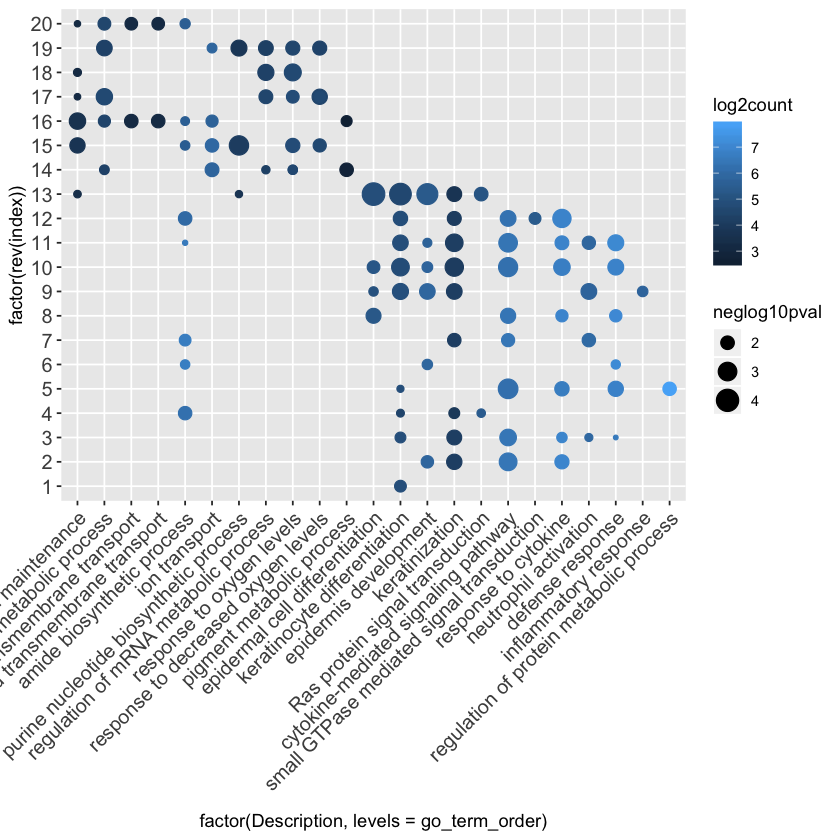

In [37]:
p = ggplot(go_term_df, aes(x= factor(Description,levels=go_term_order),y=factor(rev(index)),
                                          color=log2count, size=neglog10pval))+
    geom_point()+
#     geom_point(aes(size=score),colour="black",pch=21)+# I think this for bordering probably remove
    theme(axis.text.y = element_text(size=12),
          axis.text.x = element_text(size=12, angle = 45,hjust=1))
p 

# manually adjust go_term_order -
 move terms

In [38]:
go_term_df_filt = go_term_df#%>%


In [39]:
go_term_order

[1] "stem cell population maintenance"              
 [2] "regulation of cellular amide metabolic process"
 [3] "organic acid transmembrane transport"          
 [4] "carboxylic acid transmembrane transport"       
 [5] "amide biosynthetic process"                    
 [6] "ion transport"                                 
 [7] "purine nucleotide biosynthetic process"        
 [8] "regulation of mRNA metabolic process"          
 [9] "response to oxygen levels"                     
[10] "response to decreased oxygen levels"           
[11] "pigment metabolic process"                     
[12] "epidermal cell differentiation"                
[13] "keratinocyte differentiation"                  
[14] "epidermis development"                         
[15] "keratinization"                                
[16] "Ras protein signal transduction"               
[17] "cytokine-mediated signaling pathway"           
[18] "small GTPase mediated signal transduction"     
[19] "response to cytokine"                          
[20] "neutrophil activation"                         
[21] "defense response"                              
[22] "inflammatory response"                         
[23] "regulation of protein metabolic process"

In [40]:
# go_term_order
go_term_order  = c('regulation of cellular amide metabolic process',
'organic acid transmembrane transport',
'carboxylic acid transmembrane transport',
'ion transport',
'purine nucleotide biosynthetic process',
'regulation of mRNA metabolic process',
'response to decreased oxygen levels',
'response to oxygen levels',
'stem cell population maintenance',
'pigment metabolic process',
'amide biosynthetic process',
'epidermal cell differentiation',
'keratinocyte differentiation',
'epidermis development',
'keratinization',
'Ras protein signal transduction',
'cytokine-mediated signaling pathway',
'small GTPase mediated signal transduction',
'response to cytokine',
'neutrophil activation',
'defense response',
'inflammatory response',
'regulation of protein metabolic process'
)

In [41]:
go_term_df_filt%>%
    filter(!(Description %in% go_term_order))

ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count,vocab,tissue,vocab_pair,vocab1,vocab2,neglog10pval,log2count,index
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<int>


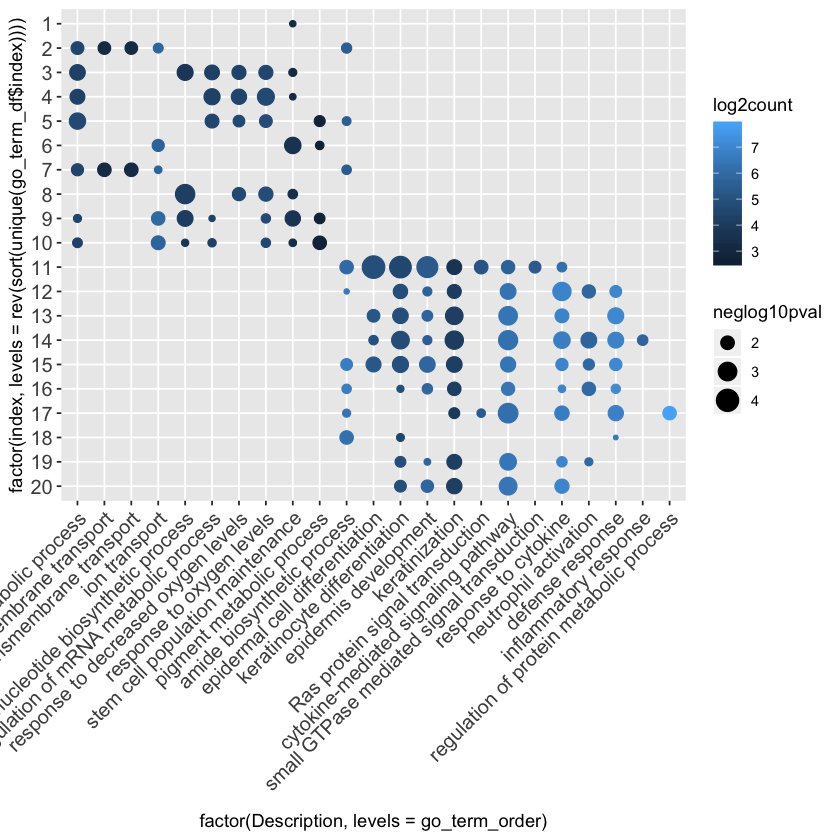

In [42]:
p = ggplot(go_term_df_filt, aes(x= factor(Description,levels=go_term_order),y=factor(index, levels=rev(sort(unique(go_term_df$index)))),
                                          color=log2count, size=neglog10pval))+
    geom_point()+
#     geom_point(aes(size=score),colour="black",pch=21)+# I think this for bordering probably remove
    theme(axis.text.y = element_text(size=12),
          axis.text.x = element_text(size=12, angle = 45,hjust=1))
p 
ggsave(file = paste0(save_prefix, "go_term_df_long.eps"),height=8, width=10)
#